# Airbnb Investment in Melbourne, Australia

### Smart property investment using data science and machine learning

#### Applied Data Science Capstone Project by IBM/Coursera

##### 19/01/2020


## Introduction : Business problem <a name="introduction"></a>

**Airbnb** has become one of the biggest players in the world's holiday accommodation industry. It exists in **more than 65,000 cities across 190+ countries all over the world**.

**Infik** published in 2019, the list of the top Airbnb cities, based on **AirDNA** database. The city of Melbourne was number 10 with 19.055 Airbnb Listings.

As the sporting and cultural capital of Australia, Melbourne has so much to offer visitors from all over the world. It is a culturally diverse city offering some of the best living standards throughout Australia.

This is where I decided to capitalize on the short-term rental demand created by Airbnb.

The study is part of 'The Battle of Neighborhoods' Coursera Applied data science capstone project. It concludes the wonderful IBM Data science Professional Certificate set of courses, which I highly recommand to anyone who is into data science and Machine Learning.

My task is to understand the revenue potential of short-term vacation in Melbourne, and explore the performance of specific neighborhoods. 

The main questions will be : 

* Are there any clusters of similar neighborhoods in Melbourne ?
* Where should I invest ? Is there any significant relationship between cluster and housing price ?
* What are the significant caracteristics that allow us to predict the property price ? And what confidence level do we have in our model ?
* Are there any specific features that can help us maximize the rental revenues ?

At the end, I would like to share with ou my insights, being able, to estimate the right price versus the estimated annual rental revenue.

## Data <a name="data"></a>

### Melbourne Housing Market

**Melbourne_housing_FULL** : The dataset was taken from Kaggle. The data was scraped from publicly available results posted every week from **Domain.com.au**. It was cleaned by Tony Pino and last updated in august 2018. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale and distance from C.B.D.

The features are :
* **_Suburb_**
* **_Address_**
* **_Rooms_**: Number of rooms
* **_Price_**: Price in Australian dollars
* **_Method_**: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
* **_Type_**: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
* **_SellerG_**: Real Estate Agent
* **_Date_**: Date sold
* **_Postcode_**
* **_Distance_**: Distance from CBD in Kilometres
* **_Regionname_**: General Region (West, North West, North, North east ...etc)
* **_Propertycount_**: Number of properties that exist in the suburb.
* **_Bedroom2_** : Scraped # of Bedrooms (from different source)
* **_Bathroom_**: Number of Bathrooms
* **_Car_**: Number of carspots
* **_Landsize_**: Land Size in Metres
* **_BuildingArea_**: Building Size in Metres
* **_YearBuilt_**: Year the house was built
* **_CouncilArea_**: Governing council for the area
* **_Lattitude_**
* **_Longtitude_**

The Melbourne Housing dataset has :
* **34857** houses sold,
* across **211** suburbs,
* with an average price of : **$1050173**,
* with **21** features

### Melbourne Airbnb Open Data

**cleansed_listings_dec18** : The dataset was also taken from Kaggle and is originally part of Inside Airbnb. This an independent, non-commercial set of tools and data that allows you to explore how Airbnb is really being used in cities around the world.
The original raw csv file has eighty-four (84) columns, some of which won't be needed for analysis such as host_url, host_about, access, interaction, summary, mainly *strings* describing the listings.

The original raw csv file is quite big and has **eighty-four** (84) columns, some of which won't be needed for analysis such as host_url, host_about, access, interaction, summary, mainly strings describing the listings.

After cleaning the dataset, keeping all relevant features, the Greater Melbourne area had:
* **22,895** listings,
* across **247** suburbs,
* hosted by **14,988** hosts,
* with an average nightly rate at **$148**.
* with **33** features left.

To answer the questions, I propose to generate three new features, for each listing :
* **_occupancy_rate_**
* **_nights_per_year_**
* **_income_per_month_**

based on **_minimum_nights_** , **_price_**, **_number_of_reviews_**, **_first_review_** and **_last_review_**, making some assumptions described later in this project.

### Exploring neighborhoods using Foursquare API

The **clustering** part of our project will be based on a list of **zip codes** extracted from both dataframes.

We can notice that the info is stored in the **_Postcode_** column in **_housing_df_** dataframe. It is stored in the **_zipcode_** column in **_airbnb_df_** dataframe.

We will use the **_airbnb_df_** zip codes, as they seem to include the **_housing_df_** ones. (**236** vs. **199**).

### import libraries and data

In [1]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
import geocoder # import geocoders
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import requests # library to handle requests
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_b80010563ad347059cff30c3cec0a156 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=os.getenv('IBM_API_KEY'),
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    ibm_service_instance_id=os.getenv('IBM_SERVICE_INSTANCE_ID'),                                                   
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.us.cloud-object-storage.appdomain.cloud')

body = client_b80010563ad347059cff30c3cec0a156.get_object(Bucket='airbnbinvestmentinmelbourneaustra-donotdelete-pr-u7czrdfljykae0',Key='airbnb_clean.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [4]:
airbnb_df = pd.read_csv(body)
airbnb_df.head()

id                                               name         suburb  \
0  12936   St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC       St Kilda   
1  38271                 Melbourne - Old Trafford Apartment        Berwick   
2  43429  Tranquil Javanese-Style Apartment in Oakleigh ...  Oakleigh East   
3  50492  St Kilda Central LUXE 2BR APT+TWO COURTYARDS+WIFI       St Kilda   
4  62606                               A Room Near the Park      Melbourne   

   zipcode            smart_location   latitude   longitude property_type  \
0     3182       St Kilda, Australia -37.859755  144.977369     Apartment   
1     3806        Berwick, Australia -38.057254  145.339356     Apartment   
2     3166  Oakleigh East, Australia -37.899601  145.114475     Apartment   
3     3182       St Kilda, Australia -37.861275  144.980379     Apartment   
4     3187      Melbourne, Australia -37.928173  145.025176         House   

         room_type  accommodates  ...  first_review  last_review  \
0  Entire home/apt             3  ...    2010-08-04   2018-11-07   
1  Entire home/apt             5  ...    2010-11-24   2018-12-01   
2  Entire home/apt             2  ...    2010-12-05   2018-12-03   
3  Entire home/apt             4  ...    2012-11-30   2018-12-02   
4     Private room             2  ...    2011-03-05   2018-11-29   

   review_scores_rating          cancellation_policy  reviews_per_month  \
0                  94.0  strict_14_with_grace_period               0.15   
1                  97.0                     flexible               1.14   
2                  97.0                     moderate               1.72   
3                  97.0  strict_14_with_grace_period               0.60   
4                  84.0                     moderate               0.22   

   min_night_per_month  min_night_per_year occupancy_rate min_income_per_year  \
0             0.642857            7.714286       0.023663         1226.571429   
1             1.628571           19.542857       0.059582         1915.200000   
2             4.914286           58.971429       0.190230         5779.200000   
3             2.571429           30.857143       0.097649         5862.857143   
4             0.628571            7.542857       0.022997          377.142857   

   min_income_per_month  
0            102.214286  
1            159.600000  
2            481.600000  
3            488.571429  
4             31.428571  

[5 rows x 27 columns]

In [5]:
print('Number of listings: ', airbnb_df.shape[0])
print('Number of features in dataset: ', airbnb_df.shape[1])
print('Average price at: ${}'.format(round(airbnb_df.price.mean())))
print('Number of suburbs: ',airbnb_df.zipcode.nunique())

Number of listings:  17492
Number of features in dataset:  27
Average price at: $137.0
Number of suburbs:  236


In [6]:
body = client_b80010563ad347059cff30c3cec0a156.get_object(Bucket='airbnbinvestmentinmelbourneaustra-donotdelete-pr-u7czrdfljykae0',Key='housing_clean.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

housing_df = pd.read_csv(body)
housing_df.head()

Suburb          Address  Rooms Type      Price Method SellerG  \
0  Abbotsford  25 Bloomburg St      2    h  1035000.0      S  Biggin   
1  Abbotsford     5 Charles St      3    h  1465000.0     SP  Biggin   
2  Abbotsford      55a Park St      4    h  1600000.0     VB  Nelson   
3  Abbotsford     124 Yarra St      3    h  1876000.0      S  Nelson   
4  Abbotsford    98 Charles St      2    h  1636000.0      S  Nelson   

         Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  2016-04-02       2.5      3067  ...         1    0     156.0          79.0   
1  2017-04-03       2.5      3067  ...         2    0     134.0         150.0   
2  2016-04-06       2.5      3067  ...         1    2     120.0         142.0   
3  2016-07-05       2.5      3067  ...         2    0     245.0         210.0   
4  2016-08-10       2.5      3067  ...         1    2     256.0         107.0   

   YearBuilt         CouncilArea Lattitude  Longtitude             Regionname  \
0       1900  Yarra City Council  -37.8079    144.9934  Northern Metropolitan   
1       1900  Yarra City Council  -37.8093    144.9944  Northern Metropolitan   
2       2014  Yarra City Council  -37.8072    144.9941  Northern Metropolitan   
3       1910  Yarra City Council  -37.8024    144.9993  Northern Metropolitan   
4       1890  Yarra City Council  -37.8060    144.9954  Northern Metropolitan   

  Propertycount  
0          4019  
1          4019  
2          4019  
3          4019  
4          4019  

[5 rows x 21 columns]

In [7]:
print('Number of houses: ', housing_df.shape[0])
print('Number of features in dataset: ', housing_df.shape[1])
print('Average price at: ${}'.format(round(housing_df.Price.mean())))
print('Number of suburbs: ',housing_df.Postcode.nunique())

Number of houses:  10502
Number of features in dataset:  21
Average price at: $1088148.0
Number of suburbs:  199


In [8]:
airbnb_df.describe()

id       zipcode      latitude     longitude  accommodates  \
count  1.749200e+04  17492.000000  17492.000000  17492.000000  17492.000000   
mean   1.771645e+07   3114.944375    -37.825612    145.008702      3.519666   
std    7.871652e+06    264.639852      0.065365      0.129127      2.194898   
min    9.835000e+03   2010.000000    -38.224427    144.531993      1.000000   
25%    1.187326e+07   3006.000000    -37.849747    144.957247      2.000000   
50%    1.908679e+07   3067.000000    -37.816785    144.977242      3.000000   
75%    2.361826e+07   3161.000000    -37.803197    145.007922      4.000000   
max    3.054094e+07  30122.000000    -37.486284    145.831408     16.000000   

          bathrooms      bedrooms          beds         price  minimum_nights  \
count  17492.000000  17492.000000  17492.000000  17492.000000    17492.000000   
mean       1.232106      1.527327      2.027155    136.887091        2.127087   
std        0.513365      0.910617      1.511341    106.254111        1.491126   
min        0.000000      0.000000      1.000000     12.000000        1.000000   
25%        1.000000      1.000000      1.000000     71.000000        1.000000   
50%        1.000000      1.000000      2.000000    114.000000        2.000000   
75%        1.000000      2.000000      2.000000    161.000000        2.000000   
max        8.000000     10.000000     20.000000    999.000000       10.000000   

       availability_365  number_of_reviews  review_scores_rating  \
count      17492.000000       17492.000000          17492.000000   
mean         270.740567          27.670135             94.255660   
std          115.957131          42.515945              8.452414   
min            3.000000           1.000000             20.000000   
25%          162.000000           3.000000             93.000000   
50%          338.000000          11.000000             97.000000   
75%          365.000000          33.000000            100.000000   
max          365.000000         538.000000            100.000000   

       reviews_per_month  min_night_per_month  min_night_per_year  \
count       17492.000000         17492.000000        17492.000000   
mean            1.593622             3.850335           46.204018   
std             1.722104             3.955892           47.470704   
min             0.010000             0.028571            0.342857   
25%             0.310000             0.857143           10.285714   
50%             1.000000             2.500000           30.000000   
75%             2.300000             5.714286           68.571429   
max            14.540000            29.700000          356.400000   

       occupancy_rate  min_income_per_year  min_income_per_month  
count    17492.000000         17492.000000          17492.000000  
mean         0.223188          6338.555150            526.767374  
std          0.228944          8594.742815            706.870352  
min          0.000939             7.200000              0.600000  
25%          0.040661          1002.428571             83.535714  
50%          0.144412          3290.400000            274.200000  
75%          0.331643          8514.514286            709.464286  
max          0.999392        145530.000000          12127.500000

### Step 1 : Zipcode dataframe preparation

Let us prepare the zipcode dataframe, for our neigbourhood clustering. As stated before, we use the airbnb dataframe.

In [9]:
airbnb_zip_df = airbnb_df[['zipcode', 'suburb']]

we drop suburb duplicates :

In [10]:
airbnb_zip_df1 = airbnb_zip_df.drop_duplicates()

and join the suburbs with the same zipcode in one string.

In [11]:
airbnb_zip_df2 = airbnb_zip_df1.groupby(['zipcode'])['suburb'].apply(lambda x: "%s" % ', '.join(x)).to_frame().reset_index()

airbnb_zip_df2.head(20)

zipcode                                             suburb
0      2010                                       Malvern East
1      3000  Melbourne, 墨爾本 Melbourne, Melbourne City, Melb...
2      3001                                          Melbourne
3      3002          Melbourne, East Melbourne, West Melbourne
4      3003  West Melbourne, Victoria, Melbourne, West Melb...
5      3004  Melbourne, St Kilda, Saint Kilda, South Melbou...
6      3006  Southbank, Melbourne, Southbank, Melbourne, So...
7      3008     Docklands, Melbourne, VIC, Dockland, Southbank
8      3011                                  Footscray, Seddon
9      3012  Maidstone, West Footscray, Kingsville, Footscr...
10     3013                                         Yarraville
11     3015    Newport, Spotswood, South Kingsville, Melbourne
12     3016                   Williamstown, Williamstown North
13     3018                        Altona, Melbourne, Seaholme
14     3019                                          Braybrook
15     3020  Sunshine, Sunshine West, Sunshine North, Albio...
16     3021                   Kealba, Saint Albans, Kings Park
17     3023  Caroline Springs, Melbourne, Victoria, AU, Cai...
18     3024                       Wyndham Vale, Mount Cottrell
19     3025                                       Altona North

### Step 2  : latitude and longitude retrieval

Now let's try the geocoder module on a random postcode, to see if the coordinates are retieved :

In [12]:
postal_code = '6791'

# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):

g = geocoder.arcgis('{}, Melbourne, Victoria'.format(postal_code))
  
lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

print(lat_lng_coords)

[-37.81738999999993, 144.96751000000006]


It is working. So let's now loop on all the postal codes :

In [13]:
postal_code_col = airbnb_zip_df2['zipcode']

n = airbnb_zip_df2.shape[0]

for postal_code , index in zip(postal_code_col , range(n)) :
    
    lat_lng_coords = None
    
    # loop until you get the coordinates
    
    while(lat_lng_coords is None):

        g = geocoder.arcgis('{}, Melbourne, Australia'.format(postal_code))
  
        lat_lng_coords = g.latlng

    airbnb_zip_df2.loc[ index , 'Latitude'] = lat_lng_coords[0]
    
    airbnb_zip_df2.loc[ index , 'Longitude'] = lat_lng_coords[1]

airbnb_zip_df2.head(235)

zipcode                                             suburb   Latitude  \
0       2010                                       Malvern East -37.817390   
1       3000  Melbourne, 墨爾本 Melbourne, Melbourne City, Melb... -37.810993   
2       3001                                          Melbourne -37.817390   
3       3002          Melbourne, East Melbourne, West Melbourne -37.815425   
4       3003  West Melbourne, Victoria, Melbourne, West Melb... -37.809103   
..       ...                                                ...        ...   
230     3978                              Cardinia, Clyde North -38.076731   
231     3980                                  Tooradin, Warneet -37.817390   
232     3981                                             Bayles -38.202890   
233     5203                             Wheelers Hill VIC 3150 -37.817390   
234     6791                               South Yarra VIC 3141 -37.817390   

      Longitude  
0    144.967510  
1    144.964485  
2    144.967510  
3    144.982591  
4    144.921020  
..          ...  
230  145.353056  
231  144.967510  
232  145.635762  
233  144.967510  
234  144.967510  

[235 rows x 4 columns]

Another way to get the coordinates is by using **Nominatim**. It works with a full adress and not a zipcode only :

In [14]:
address = 'Melbourne, Australia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


We map the retrieved zipcode points based on their coordinates :

In [15]:
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(airbnb_zip_df2['Latitude'], airbnb_zip_df2['Longitude'], airbnb_zip_df2['suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

### Step 3  : venues GET request

Now, at the stage, we can define a function which goal is to retrieve the list of venues by a specific GET request to th Foursquare API.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET') # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

melbourne_venues = getNearbyVenues(names=airbnb_zip_df2['suburb'],
                                   latitudes=airbnb_zip_df2['Latitude'],
                                   longitudes=airbnb_zip_df2['Longitude']
                                  )

Malvern East
Melbourne, 墨爾本 Melbourne, Melbourne City, Melbourne Victoria, Victoria, Docklands, Melborne, melbourne, Melbourne CBD
Melbourne
Melbourne, East Melbourne, West Melbourne
West Melbourne, Victoria, Melbourne, West Melbourne - flagstaff
Melbourne, St Kilda, Saint Kilda, South Melbourne, South Yarra
Southbank, Melbourne, Southbank, Melbourne, Southbank Melbourne, South Wharf, Collingwood, South Melbourne, Southbank, Victoria, AU, Docklands
Docklands, Melbourne, VIC, Dockland, Southbank
Footscray, Seddon
Maidstone, West Footscray, Kingsville, Footscray, Brooklyn, Melbourne
Yarraville
Newport, Spotswood, South Kingsville, Melbourne
Williamstown, Williamstown North
Altona, Melbourne, Seaholme
Braybrook
Sunshine, Sunshine West, Sunshine North, Albion, Brimbank City
Kealba, Saint Albans, Kings Park
Caroline Springs, Melbourne, Victoria, AU, Cairnlea, Deer Park, Burnside Heights
Wyndham Vale, Mount Cottrell
Altona North
Williams Landing
Seabrook, Altona Meadows, Laverton
Truganina, 

The function worked perfectly ! We retrieved a list of **3786** venues, with 283 unique categories, in the **melbourne_venues** dataframe. 

In [18]:
print(melbourne_venues.shape)
melbourne_venues.head(200)

(3786, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Malvern East              -37.81739               144.96751   
1    Malvern East              -37.81739               144.96751   
2    Malvern East              -37.81739               144.96751   
3    Malvern East              -37.81739               144.96751   
4    Malvern East              -37.81739               144.96751   
..            ...                    ...                     ...   
195     Melbourne              -37.81739               144.96751   
196     Melbourne              -37.81739               144.96751   
197     Melbourne              -37.81739               144.96751   
198     Melbourne              -37.81739               144.96751   
199     Melbourne              -37.81739               144.96751   

                   Venue  Venue Latitude  Venue Longitude  \
0      Federation Square      -37.817996       144.968194   
1     Pidapipó Gelateria      -37.817715       144.965997   
2        Degraves Street      -37.816994       144.965673   
3          Roule Galette      -37.816779       144.966295   
4            Hosier Lane      -37.816328       144.969012   
..                   ...             ...              ...   
195                ezard      -37.816075       144.968314   
196       Regent Theatre      -37.815882       144.967970   
197           Whisky Den      -37.815925       144.969552   
198  Arbory Bar & Eatery      -37.819020       144.966004   
199         Jungle Juice      -37.816722       144.965582   

            Venue Category  
0                    Plaza  
1           Ice Cream Shop  
2                     Road  
3                 Creperie  
4               Street Art  
..                     ...  
195  Australian Restaurant  
196                Theater  
197             Whisky Bar  
198                    Bar  
199              Juice Bar  

[200 rows x 7 columns]

Let  us now have a look to how many venues we get for each neighborhood :

In [19]:
melbourne_venues.groupby('Neighborhood').count().head(25)

Neighborhood Latitude  \
Neighborhood                                                                
Abbotsford, Abbotsford, Melbourne                                      19   
Airport West, Keilor Park, Niddrie, Melbourne                           1   
Alphington, Fairfield                                                   4   
Altona North                                                            1   
Altona, Melbourne, Seaholme                                             3   
Armadale, Armadale North                                               11   
Ashwood, Ashburton                                                     15   
Avondale Heights                                                        5   
Balaclava, St Kilda East, Melbourne, Saint Kild...                     13   
Balwyn                                                                 16   
Balwyn North                                                            4   
Bayswater, Bayswater North                                              4   
Beaumaris, Black Rock                                                   5   
Belgrave, Belgrave Heights, Tecoma                                      2   
Bentleigh East                                                          1   
Bentleigh, Ormond, Melbourne, McKinnon                                 31   
Berwick, Harkaway                                                      17   
Blackburn South, Blackburn, Blackburn North                            13   
Bonbeach, Chelsea, Edithvale, Chelsea Heights                           5   
Boronia                                                                16   
Box Hill, Box Hill South                                                5   
Braybrook                                                               5   
Broadmeadows, Jacana, Dallas                                            3   
Brunswick East, Melbourne, Brunswick East, Melb...                      9   
Brunswick West, Brunswick West, Melbourne, Brun...                      7   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Abbotsford, Abbotsford, Melbourne                                       19   
Airport West, Keilor Park, Niddrie, Melbourne                            1   
Alphington, Fairfield                                                    4   
Altona North                                                             1   
Altona, Melbourne, Seaholme                                              3   
Armadale, Armadale North                                                11   
Ashwood, Ashburton                                                      15   
Avondale Heights                                                         5   
Balaclava, St Kilda East, Melbourne, Saint Kild...                      13   
Balwyn                                                                  16   
Balwyn North                                                             4   
Bayswater, Bayswater North                                               4   
Beaumaris, Black Rock                                                    5   
Belgrave, Belgrave Heights, Tecoma                                       2   
Bentleigh East                                                           1   
Bentleigh, Ormond, Melbourne, McKinnon                                  31   
Berwick, Harkaway                                                       17   
Blackburn South, Blackburn, Blackburn North                             13   
Bonbeach, Chelsea, Edithvale, Chelsea Heights                            5   
Boronia                                                                 16   
Box Hill, Box Hill South                                                 5   
Braybrook                                                                5   
Broadmeadows, Jacana, Dallas                                             3   
Brunswick East, Melbou

In [20]:
print('There are {} uniques categories.'.format(len(melbourne_venues['Venue Category'].unique())))

There are 283 uniques categories.


### Step 4  : dataframe preparation to clustering

We can now proceed to clustering the neighborhoods based on their most frequented venues.

In [21]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

We now give the dataframe the right format to extract information, and calculate distances. We perform a one hot encoding on it, so as to have the **277 unique categories** as **columns**.

In [22]:
# one hot encoding
melbourne_onehot = pd.get_dummies(melbourne_venues[['Venue Category']], prefix="", prefix_sep="")

# move neighborhood column at the first column

melbourne_onehot['Neighborhood'] = melbourne_venues['Neighborhood']

cols = list(melbourne_onehot) # list of columns

# move the column to head of list using index, pop and insert

cols.insert(0, cols.pop(cols.index('Neighborhood')))

melbourne_onehot = melbourne_onehot.loc[:, cols]

melbourne_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  Airport Terminal  \
0  Malvern East                  0                   0                 0   
1  Malvern East                  0                   0                 0   
2  Malvern East                  0                   0                 0   
3  Malvern East                  0                   0                 0   
4  Malvern East                  0                   0                 0   

   American Restaurant  Antique Shop  Arcade  Art Gallery  \
0                    0             0       0            0   
1                    0             0       0            0   
2                    0             0       0            0   
3                    0             0       0            0   
4                    0             0       0            0   

   Arts & Crafts Store  Arts & Entertainment  ...  Video Store  \
0                    0                     0  ...            0   
1                    0                     0  ...            0   
2                    0                     0  ...            0   
3                    0                     0  ...            0   
4                    0                     0  ...            0   

   Vietnamese Restaurant  Whisky Bar  Wine Bar  Wine Shop  Women's Store  \
0                      0           0         0          0              0   
1                      0           0         0          0              0   
2                      0           0         0          0              0   
3                      0           0         0          0              0   
4                      0           0         0          0              0   

   Yoga Studio  Yunnan Restaurant  Zoo  Zoo Exhibit  
0            0                  0    0            0  
1            0                  0    0            0  
2            0                  0    0            0  
3            0                  0    0            0  
4            0                  0    0            0  

[5 rows x 284 columns]

In [23]:
melbourne_onehot.shape

(3786, 284)

At this stage, every single venue is represented by a line in our dataframe, with zeros in each columns except the corresponding category.

We, then, group the dataframe by neighbrhood, so as to have a dataframe present the **number of venues per category** in the corresponding column. And now our dataframe is read for clustering.

In [24]:
melbourne_grouped = melbourne_onehot.groupby('Neighborhood').mean().reset_index()
melbourne_grouped.head()

Neighborhood  Afghan Restaurant  \
0              Abbotsford, Abbotsford, Melbourne                0.0   
1  Airport West, Keilor Park, Niddrie, Melbourne                0.0   
2                          Alphington, Fairfield                0.0   
3                                   Altona North                0.0   
4                    Altona, Melbourne, Seaholme                0.0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                 0.0               0.0                  0.0           0.0   
1                 0.0               0.0                  0.0           0.0   
2                 0.0               0.0                  0.0           0.0   
3                 0.0               0.0                  0.0           0.0   
4                 0.0               0.0                  0.0           0.0   

   Arcade  Art Gallery  Arts & Crafts Store  Arts & Entertainment  ...  \
0     0.0          0.0                  0.0                   0.0  ...   
1     0.0          0.0                  0.0                   0.0  ...   
2     0.0          0.0                  0.0                   0.0  ...   
3     0.0          0.0                  0.0                   0.0  ...   
4     0.0          0.0                  0.0                   0.0  ...   

   Video Store  Vietnamese Restaurant  Whisky Bar  Wine Bar  Wine Shop  \
0          0.0                    0.0         0.0       0.0        0.0   
1          0.0                    0.0         0.0       0.0        0.0   
2          0.0                    0.0         0.0       0.0        0.0   
3          0.0                    0.0         0.0       0.0        0.0   
4          0.0                    0.0         0.0       0.0        0.0   

   Women's Store  Yoga Studio  Yunnan Restaurant  Zoo  Zoo Exhibit  
0            0.0          0.0                0.0  0.0          0.0  
1            0.0          0.0                0.0  0.0          0.0  
2            0.0          0.0                0.0  0.0          0.0  
3            0.0          0.0                0.0  0.0          0.0  
4            0.0          0.0                0.0  0.0          0.0  

[5 rows x 284 columns]

In [25]:
melbourne_grouped.shape

(201, 284)

Beow is a small for loop to print the **top 3** categories of venues per neighborhood :

In [26]:
num_top_venues = 3

for hood in melbourne_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = melbourne_grouped[melbourne_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbotsford, Abbotsford, Melbourne----
                    venue  freq
0                    Café  0.26
1                     Pub  0.16
2  Thrift / Vintage Store  0.11


----Airport West, Keilor Park, Niddrie, Melbourne----
               venue  freq
0      Grocery Store   1.0
1  Afghan Restaurant   0.0
2               Park   0.0


----Alphington, Fairfield----
         venue  freq
0  Sports Club  0.25
1         Café  0.25
2  Gas Station  0.25


----Altona North----
               venue  freq
0   Business Service   1.0
1  Afghan Restaurant   0.0
2             Office   0.0


----Altona, Melbourne, Seaholme----
            venue  freq
0  Farmers Market  0.33
1    Hockey Field  0.33
2     Pizza Place  0.33


----Armadale, Armadale North----
               venue  freq
0               Café  0.55
1  Convenience Store  0.09
2      Train Station  0.09


----Ashwood, Ashburton----
             venue  freq
0             Café  0.13
1  Thai Restaurant  0.13
2         Pharmacy  0.13


----Avondal

                venue  freq
0          Food Court  0.25
1           Bookstore  0.25
2  Italian Restaurant  0.25


----Essendon West, Essendon, Aberfeldie, Essendon, Victoria, AU----
                  venue  freq
0           Coffee Shop  0.25
1     Food & Drink Shop  0.25
2  Gym / Fitness Center  0.25


----Fawkner----
                venue  freq
0       Grocery Store  0.50
1                Pool  0.25
2  Miscellaneous Shop  0.25


----Fitzroy, Melbourne, Fitzroy, Melbourne, Fitzroy, Victoria, AU----
          venue  freq
0          Café  0.10
1           Bar  0.09
2  Cocktail Bar  0.07


----Footscray, Seddon----
                   venue  freq
0  Vietnamese Restaurant  0.12
1                    Bar  0.09
2                   Café  0.06


----Forest Hill, Nunawading, Whitehorse City----
               venue  freq
0  Korean Restaurant   1.0
1  Afghan Restaurant   0.0
2   Pedestrian Plaza   0.0


----Frankston South, Frankston----
         venue  freq
0       Bakery  0.25
1  Pizza Place  0.

                        venue  freq
0                Home Service  0.50
1        Fast Food Restaurant  0.25
2  Tourist Information Center  0.25


----Mordialloc, Aspendale, Parkdale, Aspendale Gardens, Waterways----
                  venue  freq
0  Outdoor Supply Store  0.25
1                  Café  0.25
2      Business Service  0.25


----Mount Dandenong, Mt Dandenong----
            venue  freq
0  Scenic Lookout   0.5
1          Resort   0.5
2          Office   0.0


----Mount Eliza----
              venue  freq
0               Gym  0.33
1            Garden  0.33
2  Business Service  0.33


----Mount Evelyn----
                       venue  freq
0                     Bakery  0.25
1                       Café  0.25
2  Middle Eastern Restaurant  0.25


----Mount Waverley, Mt Waverley, 芒特韦弗利区----
                   venue  freq
0            Pizza Place  0.12
1          Grocery Store  0.06
2  Australian Restaurant  0.06


----Mulgrave----
                venue  freq
0  Athletics & Sports 

       venue  freq
0  Racetrack  0.33
1  Juice Bar  0.33
2  Speakeasy  0.33


----Warburton, Millgrove, Big Pats Creek, McMahons Creek, Wesburn, East Warburton----
         venue  freq
0  Coffee Shop  0.09
1          Bar  0.08
2         Café  0.05


----Warrandyte, North Warrandyte----
            venue  freq
0  Farmers Market  0.33
1            Café  0.33
2           River  0.33


----Watsonia----
           venue  freq
0  Grocery Store  0.33
1      Gift Shop  0.33
2            Spa  0.33


----West Melbourne, Victoria, Melbourne, West Melbourne - flagstaff----
              venue  freq
0  Asian Restaurant   0.5
1       Flea Market   0.5
2      Noodle House   0.0


----Westmeadows, Attwood----
                venue  freq
0       Grocery Store  0.09
1   Fish & Chips Shop  0.09
2  Chinese Restaurant  0.09


----Wheelers Hill VIC 3150----
         venue  freq
0  Coffee Shop  0.09
1          Bar  0.08
2         Café  0.05


----Williams Landing----
                venue  freq
0  Chinese Re

As we learn in the clustering module, we define the following function which returns the dataframe with the **top 10 most common venues**.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = melbourne_grouped['Neighborhood']

for ind in np.arange(melbourne_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(melbourne_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0              Abbotsford, Abbotsford, Melbourne                  Café   
1  Airport West, Keilor Park, Niddrie, Melbourne         Grocery Store   
2                          Alphington, Fairfield           Sports Club   
3                                   Altona North      Business Service   
4                    Altona, Melbourne, Seaholme          Hockey Field   

  2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
0                   Pub  Thrift / Vintage Store        Farmers Market   
1           Zoo Exhibit                 Dog Run           Dry Cleaner   
2           Gas Station                    Café                   Bar   
3           Zoo Exhibit      Falafel Restaurant   Dumpling Restaurant   
4        Farmers Market             Pizza Place           Zoo Exhibit   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Coffee Shop                Garden   Japanese Restaurant   
1   Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
2           Flea Market           Fish Market     Fish & Chips Shop   
3   Egyptian Restaurant     Electronics Store           Event Space   
4    Falafel Restaurant           Dry Cleaner   Dumpling Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0          Burger Joint     Convenience Store        Cultural Center  
1           Event Space               Exhibit     Falafel Restaurant  
2  Fast Food Restaurant        Farmers Market    Dumpling Restaurant  
3               Exhibit                  Farm             Donut Shop  
4   Egyptian Restaurant     Electronics Store            Event Space

### Step 5  : neighborhood clustering

In [29]:
from sklearn.preprocessing import RobustScaler

We work with an initial number of clusters of 5, to build our model.

In [52]:
kclusters = 4

We now drop the **Neighorhood** column, to keep numerical values only.

In [53]:
melbourne_grouped_clustering = melbourne_grouped.drop('Neighborhood', 1)

An then we scale the data and run the algorithm.

In [54]:
scaler = RobustScaler()

scaled_df = scaler.fit_transform(melbourne_grouped_clustering)

melbourne_grouped_clustering = pd.DataFrame(scaled_df)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=50, random_state=10).fit(melbourne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 0, 0, 3, 0, 0], dtype=int32)

Now, let us find the optimum value for our number of clusters, using the **elbow method**, and **silhouette score** method.

In [33]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = range(2,15)

Sum_of_squared_distances = []

silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, n_init=50, random_state=10)
    cluster_model = clusterer.fit(melbourne_grouped_clustering)
    cluster_labels = clusterer.fit_predict(melbourne_grouped_clustering)
    silhouette_avg = silhouette_score(melbourne_grouped_clustering, cluster_labels)
    Sum_of_squared_distances.append(cluster_model.inertia_)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.6560909955629526
For n_clusters = 3 The average silhouette_score is : 0.6574517378332526
For n_clusters = 4 The average silhouette_score is : 0.6813675510902095
For n_clusters = 5 The average silhouette_score is : 0.6762851903982077
For n_clusters = 6 The average silhouette_score is : 0.6676513936979196
For n_clusters = 7 The average silhouette_score is : 0.6496954009392446
For n_clusters = 8 The average silhouette_score is : 0.6611916203644146
For n_clusters = 9 The average silhouette_score is : 0.6569350288197169
For n_clusters = 10 The average silhouette_score is : 0.6546613619412491
For n_clusters = 11 The average silhouette_score is : 0.6387002244899438
For n_clusters = 12 The average silhouette_score is : 0.6245811008925786
For n_clusters = 13 The average silhouette_score is : 0.6264832033893606
For n_clusters = 14 The average silhouette_score is : 0.61972329154

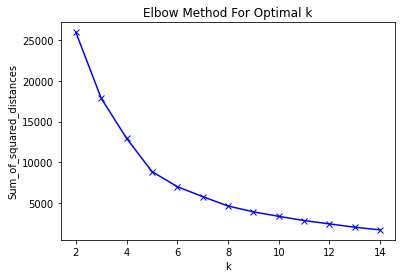

In [34]:
plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

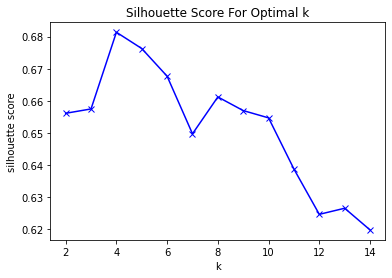

In [35]:
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score For Optimal k')
plt.show()

According to both methods, the optimum value for the number of clusters is **5**.
Now we add the **cluster label** column in our dataframes.

In [57]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

melbourne_merged = neighborhoods_venues_sorted

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

melbourne_merged = melbourne_merged.join(airbnb_zip_df2.set_index('suburb'), on='Neighborhood')

The "**most common venues**" representation will help us to understand better the clustering obtained by our model :

In [37]:
melbourne_merged.head() # check the last columns

Cluster Labels                                   Neighborhood  \
0               0              Abbotsford, Abbotsford, Melbourne   
1               0  Airport West, Keilor Park, Niddrie, Melbourne   
2               0                          Alphington, Fairfield   
3               0                                   Altona North   
4               2                    Altona, Melbourne, Seaholme   

  1st Most Common Venue 2nd Most Common Venue   3rd Most Common Venue  \
0                  Café                   Pub  Thrift / Vintage Store   
1         Grocery Store           Zoo Exhibit                 Dog Run   
2           Sports Club           Gas Station                    Café   
3      Business Service           Zoo Exhibit      Falafel Restaurant   
4          Hockey Field        Farmers Market             Pizza Place   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Farmers Market           Coffee Shop                Garden   
1           Dry Cleaner   Dumpling Restaurant   Egyptian Restaurant   
2                   Bar           Flea Market           Fish Market   
3   Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
4           Zoo Exhibit    Falafel Restaurant           Dry Cleaner   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0   Japanese Restaurant          Burger Joint     Convenience Store   
1     Electronics Store           Event Space               Exhibit   
2     Fish & Chips Shop  Fast Food Restaurant        Farmers Market   
3           Event Space               Exhibit                  Farm   
4   Dumpling Restaurant   Egyptian Restaurant     Electronics Store   

  10th Most Common Venue  zipcode   Latitude   Longitude  
0        Cultural Center     3067 -37.803706  144.999930  
1     Falafel Restaurant     3042 -37.729110  144.879564  
2    Dumpling Restaurant     3078 -37.784305  145.022333  
3             Donut Shop     3025 -37.838400  144.831738  
4            Event Space     3018 -37.863255  144.822074

In [38]:
melbourne_merged.shape

(201, 15)

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melbourne_merged['Latitude'], melbourne_merged['Longitude'], melbourne_merged['Neighborhood'], melbourne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Cluster 0 : lively neighborhoods : cafés, pubs & bars

In [72]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 0, melbourne_merged.columns[[1] + list(range(2, melbourne_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
0                    Abbotsford, Abbotsford, Melbourne                  Café   
1        Airport West, Keilor Park, Niddrie, Melbourne         Grocery Store   
2                                Alphington, Fairfield           Sports Club   
3                                         Altona North      Business Service   
5                             Armadale, Armadale North                  Café   
..                                                 ...                   ...   
195  Windsor, Prahran, Praharan, Melbourne, Prahran...                  Café   
196                                            Wollert   Rental Car Location   
198  Yarra Glen, Christmas Hills, Dixons Creek, Ste...           Coffee Shop   
199   Yarra Junction, Gladysdale, Powelltown, Gilderoy           Coffee Shop   
200                                         Yarraville        Sandwich Place   

    2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
0                     Pub  Thrift / Vintage Store        Farmers Market   
1             Zoo Exhibit                 Dog Run           Dry Cleaner   
2             Gas Station                    Café                   Bar   
3             Zoo Exhibit      Falafel Restaurant   Dumpling Restaurant   
5       Convenience Store          Breakfast Spot    Chinese Restaurant   
..                    ...                     ...                   ...   
195                   Bar     Japanese Restaurant       Thai Restaurant   
196        Soccer Stadium   Australian Restaurant          Dance Studio   
198                   Bar            Cocktail Bar                  Café   
199                   Bar            Cocktail Bar                  Café   
200                  Park              Food Truck         Shopping Mall   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Coffee Shop                Garden   Japanese Restaurant   
1     Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
2             Flea Market           Fish Market     Fish & Chips Shop   
3     Egyptian Restaurant     Electronics Store           Event Space   
5           Grocery Store         Train Station           Event Space   
..                    ...                   ...                   ...   
195           Pizza Place           Yoga Studio   Dumpling Restaurant   
196           Zoo Exhibit    Falafel Restaurant   Dumpling Restaurant   
198               Theater          Burger Joint             BBQ Joint   
199               Theater          Burger Joint             BBQ Joint   
200            Skate Park         Deli / Bodega     Electronics Store   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0            Burger Joint     Convenience Store        Cultural Center   
1             Event Space               Exhibit     Falafel Restaurant   
2    Fast Food Restaurant        Farmers Market    Dumpling Restaurant   
3                 Exhibit                  Farm             Donut Shop   
5     Dumpling Restaurant   Egyptian Restaurant      Electronics Store   
..                    ...                   ...                    ...   
195          Burger Joint     Fish & Chips Shop  Vietnamese Restaurant   
196   Egyptian Restaurant     Electronics Store            Event Space   
198      Asian Restaurant         Shopping Mall  Vietnamese Restaurant   
199      Asian Restaurant         Shopping Mall  Vietnamese Restaurant   
200           Dry Cleaner   Dumpling Restaurant    Egyptian Restaurant   

     zipcode   Latitude   Longitude  
0       3067 -37.803706  144.999930  
1       3042 -37.729110  144.879564  
2       3078 -37.784305  145.022333  
3       3025 -37.838400  144.831738  
5       3143 -37.857685  145.019494  
..       ...        ...         ...  
195     3181 -37.852930  144.996932  
196     3750 -37.621863  145.023300  
198     3775 -37.817390  144.967510  
199     3797 -37.817390  144.96751

## Cluster 1 : green neighborhoods : cafés and parks

In [60]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 1, melbourne_merged.columns[[1] + list(range(2, melbourne_merged.shape[1]))]]

Neighborhood  \
21                                           Braybrook   
56                                     Endeavour Hills   
67                  Glen Iris, Glen Iris, Victoria, AU   
68   Glen Waverley, Wheelers Hill, melbourne, Wheelers   
69             Greensborough, Saint Helena, Briar Hill   
79   Heidelberg Heights, Heidelberg West, Bellfield...   
88                                                 Kew   
89                    Kew East, Kew East, Victoria, AU   
101                                            Macleod   
148  Research, Eltham, Eltham North, Melbourne (Elt...   
154  Rosanna, Heidelberg, Eaglemont, Viewbank, HEID...   
197                                         Wonga Park   

          1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
21                         Park     Convenience Store  Vietnamese Restaurant   
56                         Park    Falafel Restaurant            Dry Cleaner   
67            Convenience Store                  Park                   Café   
68                         Park                 Diner                Dog Run   
69                          Pub                  Park                   Café   
79            Martial Arts Dojo                  Park             Playground   
88                         Park                  Café        Thai Restaurant   
89                         Park           Golf Course          Shopping Mall   
101                       Motel                  Park                   Café   
148  Construction & Landscaping                  Park      Convenience Store   
154                        Park               Theater      Fish & Chips Shop   
197                        Park          Tennis Court            Zoo Exhibit   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
21                 Bakery           Zoo Exhibit               Exhibit   
56    Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
67                Dog Run              Creperie        Cosmetics Shop   
68            Dry Cleaner   Dumpling Restaurant   Egyptian Restaurant   
69            Music Store               Exhibit           Dry Cleaner   
79                   Farm   Dumpling Restaurant   Egyptian Restaurant   
88   Fast Food Restaurant    Light Rail Station  Gym / Fitness Center   
89   Gym / Fitness Center     Electronics Store            Donut Shop   
101            Donut Shop   Dumpling Restaurant   Egyptian Restaurant   
148            Donut Shop           Flower Shop           Flea Market   
154           Zoo Exhibit               Exhibit   Dumpling Restaurant   
197            Donut Shop   Dumpling Restaurant   Egyptian Restaurant   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
21            Dry Cleaner   Dumpling Restaurant   Egyptian Restaurant   
56            Event Space               Exhibit                  Farm   
67            Flower Shop           Flea Market           Fish Market   
68      Electronics Store           Event Space               Exhibit   
69    Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
79      Electronics Store           Event Space               Exhibit   
88            Event Space   Dumpling Restaurant   Egyptian Restaurant   
89            Dry Cleaner   Dumpling Restaurant   Egyptian Restaurant   
101     Electronics Store           Event Space               Exhibit   
148           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
154   Egyptian Restaurant     Electronics Store           Event Space   
197     Electronics Store           Event Space               Exhibit   

    10th Most Common Venue  zipcode   Latitude   Longitude  
21       Electronics Store     3019 -37.786310  144.853855  
56                 Dog Run     3802 -37.969005  145.258409  
67       Fish & Chips Shop     3146 -37.856430  145.067775  
68      Falafel Restaurant     3150 -37.891721  145.175660  
69             Event Space     3088 -37.6

## Cluster 2 

In [61]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 2, melbourne_merged.columns[[1] + list(range(2, melbourne_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
4                          Altona, Melbourne, Seaholme          Hockey Field   
10                                        Balwyn North                  Café   
11                          Bayswater, Bayswater North           Pizza Place   
26                                 Bundoora, Kingsbury       Thai Restaurant   
35                Caulfield, Caulfield South, Carnegie                   Pub   
74                                        Hampton Park         Train Station   
84                    Kealba, Saint Albans, Kings Park           Pizza Place   
117                                            Mitcham           Pizza Place   
133                       Noble Park, Noble Park North                 Hotel   
136   Oakleigh East, Oakleigh, Huntingdale, Hughesdale      Asian Restaurant   
151                           Ringwood East, Heathmont                  Café   
174  Sunshine, Sunshine West, Sunshine North, Albio...             BBQ Joint   

             2nd Most Common Venue 3rd Most Common Venue  \
4                   Farmers Market           Pizza Place   
10                            Park                   Spa   
11                        Pie Shop        Ice Cream Shop   
26   Paper / Office Supplies Store           Supermarket   
35                     Pizza Place                   Gym   
74                     Pizza Place           Zoo Exhibit   
84            Fast Food Restaurant          Tennis Court   
117                Badminton Court                   Gym   
133           Fast Food Restaurant           Pizza Place   
136                      BBQ Joint            Restaurant   
151             Seafood Restaurant                  Park   
174                          Trail           Pizza Place   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
4                Zoo Exhibit    Falafel Restaurant           Dry Cleaner   
10               Pizza Place               Exhibit           Dry Cleaner   
11               Gas Station   Dumpling Restaurant   Egyptian Restaurant   
26               Pizza Place    Light Rail Station           Zoo Exhibit   
35             Deli / Bodega  Other Great Outdoors     Fish & Chips Shop   
74        Falafel Restaurant           Dry Cleaner   Dumpling Restaurant   
84   Health & Beauty Service               Exhibit           Dry Cleaner   
117              Zoo Exhibit    Falafel Restaurant   Dumpling Restaurant   
133              Sports Club          Home Service               Exhibit   
136              Pizza Place                  Farm   Dumpling Restaurant   
151              Pizza Place               Exhibit           Dry Cleaner   
174              Zoo Exhibit               Exhibit           Dry Cleaner   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
4     Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
10    Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
11      Electronics Store           Event Space               Exhibit   
26                Exhibit   Dumpling Restaurant   Egyptian Restaurant   
35   Fast Food Restaurant        Farmers Market                  Farm   
74    Egyptian Restaurant     Electronics Store           Event Space   
84    Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
117   Egyptian Restaurant     Electronics Store           Event Space   
133            Donut Shop           Dry Cleaner   Dumpling Restaurant   
136   Egyptian Restaurant     Electronics Store           Event Space   
151   Dumpling Restaurant   Egyptian Restaurant     Electronics Store   
174   Dumpling Restaurant   Egyptian Restaurant     Electronics Store   

    10th Most Common Venue  zipcode   Latitude   Longitude  
4              Event Space     3018 -37.863255  144.822074  
10             Event Space     3104 -37.790820  145.084605  
11      Falafel Restaurant     3153 -37.835922  145.272060  
26       Electronics Store     3083 -

## Cluster 3 

In [62]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 3, melbourne_merged.columns[[1] + list(range(2, melbourne_merged.shape[1]))]]

Neighborhood      1st Most Common Venue  \
7                                Avondale Heights               Dance Studio   
13             Belgrave, Belgrave Heights, Tecoma                     Bakery   
34       Caulfield North, Melbourne, Victoria, AU                     Bakery   
63                     Frankston South, Frankston       Fast Food Restaurant   
105                     Meadow Heights, Melbourne  Middle Eastern Restaurant   
107  Melbourne, Box Hill North, Mont Albert North         Italian Restaurant   
115                                       Mentone                Fish Market   
125                                  Mount Evelyn  Middle Eastern Restaurant   
127                                      Mulgrave                     Bakery   
142                Pascoe Vale South, Pascoe Vale                     Bakery   
149                                     Reservoir                     Bakery   
160            Seabrook, Altona Meadows, Laverton                     Bakery   
193                              Williams Landing          Korean Restaurant   

    2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
7       Electronics Store          Liquor Store                Pizza Place   
13                   Café            Food Court        Dumpling Restaurant   
34   Gym / Fitness Center                  Café  Middle Eastern Restaurant   
63            Pizza Place                Bakery                   Pharmacy   
105                Bakery           Pizza Place              Shopping Mall   
107                Bakery                  Café                       Park   
115    Chinese Restaurant           Pizza Place                     Bakery   
125                  Café       Automotive Shop                     Bakery   
127    Athletics & Sports                  Park          Electronics Store   
142                  Café           Supermarket      Australian Restaurant   
149         Grocery Store  Fast Food Restaurant                 Restaurant   
160      Department Store           Supermarket       Fast Food Restaurant   
193         Shopping Mall    Chinese Restaurant              Grocery Store   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
7                  Bakery    Falafel Restaurant   Dumpling Restaurant   
13    Egyptian Restaurant     Electronics Store           Event Space   
34             Steakhouse                  Park    Chinese Restaurant   
63            Zoo Exhibit               Exhibit           Dry Cleaner   
105         Grocery Store               Exhibit           Dry Cleaner   
107           Pizza Place              Pharmacy              Bus Stop   
115           Zoo Exhibit               Exhibit           Dry Cleaner   
125           Zoo Exhibit    Falafel Restaurant   Egyptian Restaurant   
127                  Café  Arts & Entertainment   Egyptian Restaurant   
142                  Farm   Egyptian Restaurant     Electronics Store   
149           Coffee Shop              Pharmacy           Zoo Exhibit   
160         Shopping Mall              Pharmacy           Dry Cleaner   
193                Bakery  Fast Food Restaurant        Farmers Market   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
7     Egyptian Restaurant           Event Space                Exhibit   
13                Exhibit    Falafel Restaurant            Zoo Exhibit   
34    Egyptian Restaurant     Electronics Store            Event Space   
63    Dumpling Restaurant   Egyptian Restaurant      Electronics Store   
105   Dumpling Restaurant   Egyptian Restaurant      Electronics Store   
107           Event Space   Dumpling Restaurant    Egyptian Restaurant   
115   Dumpling Restaurant   Egyptian Restaurant      Electronics Store   
125     Electronics Store           Event Space                Exhibit   
127           Event Space               Exhibit     Falafel Restaurant   
142           Event Space               Exhibit     Falafel 

In [65]:
airbnb_clustered = airbnb_df

airbnb_clustered = airbnb_clustered.join(melbourne_merged.set_index('zipcode'), on='zipcode')

airbnb_clustered.shape

(17492, 41)

In [66]:
airbnb_grouped = airbnb_clustered.groupby('Cluster Labels').mean().reset_index()

airbnb_grouped[['Cluster Labels','min_income_per_year']].head(10)

Cluster Labels  min_income_per_year
0             0.0          6541.841340
1             1.0          4159.942449
2             2.0          2873.218444
3             3.0          3913.437750

In [67]:
from folium.plugins import FastMarkerCluster

airbnb_clustered.dropna(subset=['Cluster Labels'], axis=0, inplace=True)

airbnb_clustered['Cluster Labels'] = airbnb_clustered['Cluster Labels'].astype('int')

subset_of_df = airbnb_clustered.sample(n=2000)

# create map
airbnb_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
                                            
markers_colors = []
                                            
for lat, lon, cluster, income in zip(subset_of_df['latitude'], subset_of_df['longitude'], subset_of_df['Cluster Labels'], subset_of_df['min_income_per_year']):
    label = folium.Popup(' Cluster ' + str(cluster) + ' yearly income ' + str(int(income)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(airbnb_map_clusters)
    
airbnb_map_clusters

In [68]:
housing_clustered = housing_df

housing_clustered = housing_clustered.join(melbourne_merged.set_index('zipcode'), on='Postcode')

housing_clustered.shape

(10502, 35)

In [69]:
housing_grouped = housing_clustered.groupby('Cluster Labels').median()

housing_grouped.head(10)

Rooms      Price  Distance  Postcode  Bedroom2  Bathroom  Car  \
Cluster Labels                                                                  
0.0                 3   937000.0       9.0      3082         3         2    2   
1.0                 3  1009500.0       9.2      3095         3         2    2   
2.0                 3   800000.0      12.6      3083         3         2    2   
3.0                 3   726250.0      11.2      3073         3         1    2   

                Landsize  BuildingArea  YearBuilt  Lattitude  Longtitude  \
Cluster Labels                                                             
0.0                339.0         132.0       1970  -37.81180   144.99217   
1.0                592.0         145.0       1968  -37.78965   145.06160   
2.0                545.0         135.0       1970  -37.79520   145.03180   
3.0                486.0         120.0       1970  -37.72612   145.00185   

                Propertycount   Latitude   Longitude  
Cluster Labels                                        
0.0                      6567 -37.817390  144.995555  
1.0                      7392 -37.786310  145.067775  
2.0                      5051 -37.790820  145.025597  
3.0                      7485 -37.733552  145.002308

In [70]:
housing_clustered.dropna(subset=['Cluster Labels'], axis=0, inplace=True)

housing_clustered['Cluster Labels'] = housing_clustered['Cluster Labels'].astype('int')

subset_of_df = housing_clustered.sample(n=1000)

# create map
housing_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
                                            
markers_colors = []
                                            
for lat, lon, cluster, price in zip(subset_of_df['Lattitude'], subset_of_df['Longtitude'], subset_of_df['Cluster Labels'], subset_of_df['Price']):
    label = folium.Popup(' Cluster ' + str(cluster) + ' price ' + str(int(price)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(housing_map_clusters)
    
housing_map_clusters

In [71]:
airbnb_clustered.to_csv(r'airbnb_clustered.csv',index=False)
housing_clustered.to_csv(r'housing_clustered.csv',index=False)